In [ ]:
import os
import scipy.io
from scipy.io import loadmat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
from matplotlib.gridspec import GridSpec


%matplotlib widget


data_dir = r'/home/kouroshmaboudi/Documents/Learned_tuning_Python/Datasets'
state_detection_dir =  r'/home/kouroshmaboudi/Documents/NCMLproject/StateDetectionResults/'

sessions = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

included_session_IDX = [x for x in range(17) if x not in (5, 12, 13)]
included_session_IDX.append(5)
# included_session_IDX = [0]

sessions = [sessions[i] for i in included_session_IDX]

session_name_mapping = {'Achilles_10252013': 'Rat A linear',
                        'Achilles_11012013': 'Rat A circular',
                        'Buddy_06272013': 'Rat B',
                        'Cicero_09172014': 'Rat C',
                        'Gatsby_08282013':'Rat G',
                        'RatN_Day2_2019-10-11_03-58-54': 'Rat N',
                        'RatS-Day2-2020-11-27_10-22-29': 'Rat S',
                        'RatU_Day2NSD_2021-07-24_08-16-38': 'Rat U',
                        'RatV_Day1NSD_2021-10-02_08-10-23': 'Rat V linear',
                        'RatV_Day3NSD_2021-10-07_08-10-12': 'Rat V semicircular',
                        'Roy-maze1': 'Rat R',
                        'Ted-maze1': 'Rat T linear',
                        'Ted-maze2': 'Rat T L shape',
                        'Ted-maze3': 'Rat T U shape',
                        'Kevin-maze1': 'Rat K'}

ripple_duration_df = pd.DataFrame(columns=['sessionName', 'duration', 'brainState'])


for session_idx, session_name in enumerate(sessions):

    print(session_name)

    session_dataset_path = os.path.join(data_dir, session_name)
    session_number = included_session_IDX[session_idx]


    #--------------------------------------------------------------------------------------------
    # Load epochs information

    filename = f'{session_name}.fileInfo_for_python.mat'
    file_path = os.path.join(session_dataset_path, filename)

    mat_file = scipy.io.loadmat(file_path)
    session_info = mat_file["fileInfo"]

    epochs = session_info["behavior"][0][0][0][0]["time"]

    epoch_names = ['PRE', 'MAZE', 'POST']


    #-------------------------------------------------------------------------------------------
    # Loading the population burst evenst with all their corresponding measured lfp features

    overwrite = False # in case we need to read the .mat file again, if there was a change

    filename = f'{session_name}.PBEs.pkl'
    file_path = os.path.join(session_dataset_path, filename)

    if os.path.exists(file_path) and overwrite == False:

        # PBEs = np.load(file_path, allow_pickle=True)
        PBEs = pd.read_pickle(file_path)
    else: # if it doesn't exist then read it from the .mat file

        filename = f'{session_name}.PBEInfo_replayScores_with_spindle_and_deltaPowers.mat'
        file_path = os.path.join(session_dataset_path, filename)
        f = h5py.File(file_path, "r")
        PBEInfo = f['PBEInfo_replayScores']    
       

        # Store the population burst events in a pandas DataFrame
        num_PBEs = PBEInfo["fr_1msbin"].shape[0]
        attributes = list(PBEInfo.keys())

        PBEs = pd.DataFrame(columns=[attr for attr in attributes[1:] if attr not in ['posteriorProbMat', 'postMat_nonNorm']])

        # Loop over the PBEs and add each one as a row to the DataFrame
        num_dots = int(num_PBEs * (10/100))
        count = 0

        for pbe in range(num_PBEs): #  
  
            for attr in PBEs.columns:
                ref = PBEInfo[attr][pbe][0]
                obj = f[ref]

                if attr in ['epoch', 'brainState']: # convert the ascii code to string
                    arr = np.array(obj).flatten()
                    epoch = "".join(chr(code) for code in arr)
                    PBEs.at[pbe, attr] = epoch
                elif attr in ['fr_1msbin', 'fr_20msbin', 'posteriorProbMat', 'postMat_nonNorm']: # no need to flatten
                    arr = np.array(obj)
                    PBEs.at[pbe, attr] = arr
                else: 
                    arr = np.array(obj).flatten()
                    PBEs.at[pbe, attr] = arr

        if (pbe+1) % num_dots == 1:
            count += 1
            message = "Importing PBEs" + "." * count
            print(message, end="\r")

        print("All PBEs were imported") 
    
        filename = f'{session_name}.PBEs.pkl'
        file_path = os.path.join(session_dataset_path, filename)
        PBEs.to_pickle(file_path)

    num_PBEs = PBEs.shape[0]
    

    for pbe in range(num_PBEs):
        epoch_ascii = PBEs.loc[pbe, 'sessionName']
        sessionName = "".join(chr(code) for code in epoch_ascii)
        PBEs.at[pbe, 'sessionName'] = sessionName

    ripple_duration_df = pd.concat([ripple_duration_df, PBEs[['sessionName', 'duration', 'brainState']]], ignore_index = True)

ripple_durations = ripple_duration_df['duration']
ripple_durations = np.concatenate(ripple_durations)

ripple_duration_df['duration'] = ripple_durations
ripple_duration_df['pooled'] = ['pooled']*len(ripple_duration_df)

NREM_QW_idx = ripple_duration_df['brainState'].isin(['NREM', 'QW'])
ripple_duration_df = ripple_duration_df.loc[NREM_QW_idx]


#### Plot the distribution of ripple events for individual sessions and pooled data

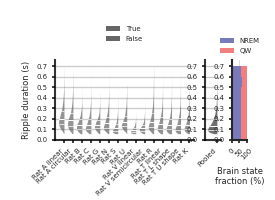

In [307]:
#---------------------------------------------------------------------------------------------------------
# Define a function to plot violin plots
def plot_violin(ax, data, color, xvar, yvar):
    alpha = 0.7
    custom_pallete = [color]*len(data[xvar].unique())
    vio = sns.violinplot(data=data, x = xvar, y = yvar, hue=True, palette=custom_pallete, hue_order=[True, False], split = True, cut=0, inner='quartiles', ax=ax, linewidth=0, capstyle='butt', side='right', scale='width', width=1.2)
    for violin, curr_alpha in zip(ax.collections[::1], [alpha] * len(data[xvar].unique())):
        violin.set_alpha(curr_alpha)
    for l in ax.lines:
        l.set_linestyle('-')
        l.set_linewidth(0.5)
        l.set_color('white')
        l.set_alpha(1)
    for l in ax.lines[1::3]:
        l.set_linestyle('-')
        l.set_linewidth(.75)
        l.set_color('white')
        l.set_alpha(1)
    ax.grid(axis='y', color=(.8,.8,.8), linewidth=1)
    for axis in ['left', 'bottom']:
        ax.spines[axis].set_linewidth(1.5)
        ax.spines[axis].set_color((0,0,0,0.8))

    vio.legend(loc="upper center", bbox_to_anchor=(0.5, 1.5))
    vio.set_title("")
    


#------------------------------------------------------------------------------------------------------------
# Set up colors ans styles

sns.set_style('whitegrid') # Set style and context
sns.set_context('paper')

custom_params = {"axes.spines.top": False, "axes.spines.right": False}
sns.set_theme(style="ticks", rc=custom_params)

plt.rcParams.update({
    'font.size':6,
    'axes.linewidth':1.5,
    'pdf.fonttype':42,
    'ps.fonttype':42,
    'axes.labelsize':6,
    'axes.titlesize':8,
    'xtick.labelsize':5,
    'ytick.labelsize':5,
    'legend.fontsize':5,
    'legend.title_fontsize':6,
    'legend.frameon': False,
    'legend.markerscale':2,
    'xtick.major.size':2,
    'ytick.major.size':2
})

colors = dict()
colors['NREM'] = '#787BBB'
colors['REM'] = '#B4B1D8'
colors['WAKE'] = '#F8B1B3'
colors['QW'] = '#F37E80'

#-------------------------------------------------------------------------------------------------------------
# Generate the figure

plotheight = 2
plotwidth = 2.75
font_size = 6

fig = plt.figure()
fig.set_size_inches([plotwidth, plotheight])
gs = GridSpec(nrows=1, ncols=3, figure=fig, width_ratios=[0.9, 0.1, 0.1]) 


#--------------------------------------------------------------------------------------------------------------
# Distribution of ripple duration for individual sessions

ax0 = fig.add_subplot(gs[0])
xvar = 'sessionName'
yvar = 'duration'
plot_violin(ax0, ripple_duration_df, (0.4, 0.4, 0.4), xvar, yvar)

ax0.set_ylim([0, 0.76])
ax0.set_yticks(np.arange(0, 0.75,0.1))
ax0.set_ylabel('Ripple duration (s)')

old_xlim = ax0.get_xlim()
ax0.set_xlim([old_xlim[0]-0.5, old_xlim[1]])

old_labels = ax0.get_xticklabels()
ax0.set_xticklabels([session_name_mapping[label.get_text()] for label in old_labels], rotation=45, ha='right')


#-------------------------------------------------------------------------------------------------------------
# Distribution of ripple duration for pooled data

ax1 = fig.add_subplot(gs[1], sharey=ax0)

xvar = 'pooled'
yvar = 'duration'
plot_violin(ax1, ripple_duration_df, (0.2, 0.2, 0.2), xvar, yvar)

ax1.legend("")
ax1.set_ylim([0, 0.76])
# ax1.set_yticks([])
# ax1.spines['left'].set_visible(False)
# ax1.set_yticklabels([])
ax1.grid(axis='y', color=(.8,.8,.8), linewidth=0.5)
ax1.set_ylabel("")
ax1.set_xlabel("")
ax1.set_xticklabels(['Pooled'], rotation=45, ha='right')
old_xlim = ax1.get_xlim()
ax1.set_xlim([old_xlim[0]-0.25, old_xlim[1]-0.25])


#---------------------------------------------------------------------------------------------------------------
# NREM and QW stacked barplot for the pooled data
ax2 = fig.add_subplot(gs[2], sharey=ax0)
ripple_duration_bin_Edges = np.arange(0, 0.71, 0.1)
num_bins = len(ripple_duration_bin_Edges)-1
binCenters = ripple_duration_bin_Edges[:-1]+0.05

percent_PBEs_brainState_ripple_duration_bin = np.full((num_bins, 2), np.nan)
for bin in range(num_bins):

    inside_bin_idx = (ripple_duration_df['duration'] >= ripple_duration_bin_Edges[bin]) & (ripple_duration_df['duration'] < ripple_duration_bin_Edges[bin+1]) 
    total_num_PBEs_within_bin = len(np.where(inside_bin_idx)[0])
    
    for state_idx, state in enumerate(['NREM', 'QW']):
        curr_PBE_subset = np.where((ripple_duration_df['brainState'] == state) & inside_bin_idx)[0]
        percent_PBEs_brainState_ripple_duration_bin[bin, state_idx] = len(curr_PBE_subset)/total_num_PBEs_within_bin * 100



ax2.barh(binCenters, percent_PBEs_brainState_ripple_duration_bin[:, 0], color = colors['NREM'], edgecolor = 'none', height=0.1, label='NREM')
ax2.barh(binCenters, percent_PBEs_brainState_ripple_duration_bin[:, 1], left=percent_PBEs_brainState_ripple_duration_bin[:, 0], color = colors['QW'], edgecolor = 'none', height=0.1, label='QW')
ax2.legend(loc="upper center", bbox_to_anchor=(0.5, 1.35))
ax2.set_xticks([0,50,100])
ax2.set_xticklabels([0,50, 100], rotation=45)
ax2.grid(axis='x', color=(.8,.8,.8), linewidth=0.5)
ax2.set_xlabel('Brain state\nfraction (%)')



plt.subplots_adjust(left=0.2, right=0.9, top=0.70, bottom=0.3)
plt.show()

filename = 'pooled_ripple_duration_1.pdf'
file_path = os.path.join(data_dir, filename)
plt.savefig(file_path, format='pdf', dpi=300)

